## 本章节内容： 

一、为模型准备数据

1.数据劈分

二、机器学习模型

1.决策树模型

2.随机森林模型

3.过拟合、欠拟合

4.模型评价

<h1> 1.为模型准备数据 </h1>

通过前面的特种工程的特征构建，特征相关性分析筛选，特征重要性排名，我们选出候选特征。同时，我们通过自定义的

标签方法对数据打标签。这些数据合并后，送入预处理阶段进行劈分，为后面的建模做准备。通常数据可以分成至少两份。

一份是IS(In Sample样本内）用于建模，另外一份是OOS(Out Of Sample样本外）用于评价模型。OOS样本外有需要还可以

分成校验集和测试集，所谓校验集用于评价模型，所谓测试集是模型构建完毕后用于测试模型。



In [2]:
import numpy as np
import pandas as pd
import talib

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.finance import candlestick2_ohlc

pd.set_option('display.max_rows', 15)
pd.set_option('display.max_columns', 50)

#获取数据，设置索引
def get_data(filename):
    data=pd.read_excel(filename)
    data['datetime']=pd.to_datetime(data['datetime'])
    data=data.set_index('datetime')
    return data

#计算指标
def get_factors(data,
                drop=False):
    '''
    :param data: 含Open,High,Low,Close,Volume字段的带时间索引的数据表格
    :return:
    '''
    index=data.index
    Open =data.Open.astype(float).values
    High =data.High.astype(float).values
    Low  =data.Low.astype(float).values
    Close=data.Close.astype(float).values
    Volume=data.Volume.astype(float).values
    
    tmp = pd.DataFrame()
    tmp['tradeTime'] = index
    
    #-------------------基本变量-------------------
    tmp['open'] = Open
    tmp['high'] = High
    tmp['low']  = Low
    tmp['close']= Close
    tmp['volume']=Volume
    tmp['log_return']=np.log(tmp['close']/tmp['close'].shift(1))
    tmp['volume_diff']=tmp['volume'].diff()
    #------------------talib特征------------------
    # 累积/派发线（Accumulation / Distribution Line，该指标将每日的成交量通过价格加权累计，
    # 用以计算成交量的动量。属于趋势型因子
    tmp['AD'] = talib.AD(High, Low, Close, Volume)

    # 佳庆指标（Chaikin Oscillator），该指标基于AD曲线的指数移动均线而计算得到。属于趋势型因子
    tmp['ADOSC'] = talib.ADOSC(High, Low, Close, Volume, fastperiod=3, slowperiod=10)

    # 平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADX'] = talib.ADX(High, Low, Close, timeperiod=14)

    # 相对平均动向指数，DMI因子的构成部分。属于趋势型因子
    tmp['ADXR'] = talib.ADXR(High, Low, Close, timeperiod=14)

    # 绝对价格振荡指数
    tmp['APO'] = talib.APO(Close, fastperiod=12, slowperiod=26)

    # Aroon通过计算自价格达到近期最高值和最低值以来所经过的期间数，帮助投资者预测证券价格从趋势到区域区域或反转的变化，
    # Aroon指标分为Aroon、AroonUp和AroonDown3个具体指标。属于趋势型因子
    tmp['AROONDown'], tmp['AROONUp'] = talib.AROON(High, Low, timeperiod=14)
    tmp['AROONOSC'] = talib.AROONOSC(High, Low, timeperiod=14)

    # 均幅指标（Average TRUE Ranger），取一定时间周期内的股价波动幅度的移动平均值，
    # 是显示市场变化率的指标，主要用于研判买卖时机。属于超买超卖型因子。
    tmp['ATR14'] = talib.ATR(High, Low, Close, timeperiod=14)
    tmp['ATR6']  = talib.ATR(High, Low, Close, timeperiod=6)

    # 布林带
    tmp['Boll_Up'], tmp['Boll_Mid'], tmp['Boll_Down'] = talib.BBANDS(Close, timeperiod=20, nbdevup=2, nbdevdn=2,
                                                                     matype=0)

    # 均势指标
    tmp['BOP'] = talib.BOP(Open, High, Low, Close)

    # 5日顺势指标（Commodity Channel Index），专门测量股价是否已超出常态分布范围。属于超买超卖型因子。
    tmp['CCI5'] = talib.CCI(High, Low, Close, timeperiod=5)
    tmp['CCI10'] = talib.CCI(High, Low, Close, timeperiod=10)
    tmp['CCI20'] = talib.CCI(High, Low, Close, timeperiod=20)
    tmp['CCI88'] = talib.CCI(High, Low, Close, timeperiod=88)

    # 钱德动量摆动指标（Chande Momentum Osciliator），与其他动量指标摆动指标如相对强弱指标（RSI）和随机指标（KDJ）不同，
    # 钱德动量指标在计算公式的分子中采用上涨日和下跌日的数据。属于超买超卖型因子
    tmp['CMO_Close'] = talib.CMO(Close, timeperiod=14)
    tmp['CMO_Open'] = talib.CMO(Close, timeperiod=14)

    # DEMA双指数移动平均线
    tmp['DEMA6'] = talib.DEMA(Close, timeperiod=6)
    tmp['DEMA12'] = talib.DEMA(Close, timeperiod=12)
    tmp['DEMA26'] = talib.DEMA(Close, timeperiod=26)

    # DX 动向指数
    tmp['DX'] = talib.DX(High, Low, Close, timeperiod=14)

    # EMA 指数移动平均线
    tmp['EMA6'] = talib.EMA(Close, timeperiod=6)
    tmp['EMA12'] = talib.EMA(Close, timeperiod=12)
    tmp['EMA26'] = talib.EMA(Close, timeperiod=26)

    # KAMA 适应性移动平均线
    tmp['KAMA'] = talib.KAMA(Close, timeperiod=30)

    # MACD
    tmp['MACD_DIF'], tmp['MACD_DEA'], tmp['MACD_bar'] = talib.MACD(Close, fastperiod=12, slowperiod=24, signalperiod=9)

    # 中位数价格 不知道是什么意思
    tmp['MEDPRICE'] = talib.MEDPRICE(High, Low)

    # 负向指标 负向运动
    tmp['MiNUS_DI'] = talib.MINUS_DI(High, Low, Close, timeperiod=14)
    tmp['MiNUS_DM'] = talib.MINUS_DM(High, Low, timeperiod=14)

    # 动量指标（Momentom Index），动量指数以分析股价波动的速度为目的，研究股价在波动过程中各种加速，
    # 减速，惯性作用以及股价由静到动或由动转静的现象。属于趋势型因子
    tmp['MOM'] = talib.MOM(Close, timeperiod=10)

    # 归一化平均值范围
    tmp['NATR'] = talib.NATR(High, Low, Close, timeperiod=14)

    # OBV 	能量潮指标（On Balance Volume，OBV），以股市的成交量变化来衡量股市的推动力，
    # 从而研判股价的走势。属于成交量型因子
    tmp['OBV'] = talib.OBV(Close, Volume)

    # PLUS_DI 更向指示器
    tmp['PLUS_DI'] = talib.PLUS_DI(High, Low, Close, timeperiod=14)
    tmp['PLUS_DM'] = talib.PLUS_DM(High, Low, timeperiod=14)

    # PPO 价格振荡百分比
    tmp['PPO'] = talib.PPO(Close, fastperiod=6, slowperiod=26, matype=0)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    # 通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROC6'] = talib.ROC(Close, timeperiod=6)
    tmp['ROC20'] = talib.ROC(Close, timeperiod=20)
    # 12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    # 通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    # 达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    # 属于成交量的反趋向指标。属于成交量型因子
    tmp['VROC6'] = talib.ROC(Volume, timeperiod=6)
    tmp['VROC20'] = talib.ROC(Volume, timeperiod=20)

    # ROC 6日变动速率（Price Rate of Change），以当日的收盘价和N天前的收盘价比较，
    # 通过计算股价某一段时间内收盘价变动的比例，应用价格的移动比较来测量价位动量。属于超买超卖型因子。
    tmp['ROCP6'] = talib.ROCP(Close, timeperiod=6)
    tmp['ROCP20'] = talib.ROCP(Close, timeperiod=20)
    # 12日量变动速率指标（Volume Rate of Change），以今天的成交量和N天前的成交量比较，
    # 通过计算某一段时间内成交量变动的幅度，应用成交量的移动比较来测量成交量运动趋向，
    # 达到事先探测成交量供需的强弱，进而分析成交量的发展趋势及其将来是否有转势的意愿，
    # 属于成交量的反趋向指标。属于成交量型因子
    tmp['VROCP6'] = talib.ROCP(Volume, timeperiod=6)
    tmp['VROCP20'] = talib.ROCP(Volume, timeperiod=20)

    # RSI
    tmp['RSI'] = talib.RSI(Close, timeperiod=14)

    # SAR 抛物线转向
    tmp['SAR'] = talib.SAR(High, Low, acceleration=0.02, maximum=0.2)

    # TEMA
    tmp['TEMA6'] = talib.TEMA(Close, timeperiod=6)
    tmp['TEMA12'] = talib.TEMA(Close, timeperiod=12)
    tmp['TEMA26'] = talib.TEMA(Close, timeperiod=26)

    # TRANGE 真实范围
    tmp['TRANGE'] = talib.TRANGE(High, Low, Close)

    # TYPPRICE 典型价格
    tmp['TYPPRICE'] = talib.TYPPRICE(High, Low, Close)

    # TSF 时间序列预测
    tmp['TSF'] = talib.TSF(Close, timeperiod=14)

    # ULTOSC 极限振子
    tmp['ULTOSC'] = talib.ULTOSC(High, Low, Close, timeperiod1=7, timeperiod2=14, timeperiod3=28)

    # 威廉指标
    tmp['WILLR'] = talib.WILLR(High, Low, Close, timeperiod=14)

    if drop:
        tmp.dropna(inplace=True)

    tmp.set_index('tradeTime', inplace=True)

    return tmp

#函数：打标签（极少数无波动的标签为0的去掉）
def get_labeling(closeseries, bar_num):
    '''
    :param closeseries:   bar的收盘价序列
    :param bar_num:       后N根bar
    :return:  label序列  
    '''
    ret=closeseries.shift(-bar_num)/closeseries - 1.0  #后N bar的收益率
    ret=ret.dropna(how='any')
    bin=np.sign(ret.values)
    bin=pd.Series(bin,index=ret.index,name='bin')
    bin=bin[bin!=0.0]
    return bin

#数据预处理，劈分训练测试集
def data_preprocess(df,featList,split):
    
    if not('bin' in featList):
        featList += ['bin']
        
    _df=df[featList].copy(deep=True)
    _split=int(len(df)*split)
    Xtrain,Xtest = _df.drop(['bin'],1).iloc[:-_split],_df.drop(['bin'],1).iloc[-_split:] #x部分必须删掉标签
    ytrain,ytest = _df['bin'].reindex(Xtrain.index),_df['bin'].reindex(Xtest.index)
    
    return Xtrain,Xtest,ytrain,ytest

filename='C:\\HiData\\Users\\ShenHong\\合作\\融秀\\AI量化初级\\notebook\\SHFE_ru_HOT_5.xlsx'
data=get_data(filename)
factor=get_factors(data,drop=True)
bin=get_labeling(factor['close'],5)
all=pd.concat([factor,bin],1)
all.dropna(how='any',inplace=True)
featList=[
    'high','low',
    'volume_diff',
    'log_return',
    'AD','ADX',
    'APO','CCI5',
    'CCI10','DX',
    'EMA6','EMA12',
    'KAMA','OBV',
    'ROC6','SAR',
    'WILLR'
]
Xtrain,Xtest,ytrain,ytest=data_preprocess(all,featList,0.2)
print('训练集样本数=%d 测试集样本数=%d'%(len(Xtrain),len(Xtest)))

训练集样本数=54073 测试集样本数=13518


<h1> 2.机器学习模型 </h1>

<h2> 2.1 预备知识 </h2>
<h3> 2.1.1 算法分类 </h3>

机器学习的算法繁多，其中很多算法是一类算法，而有些算法又是从其他算法中衍生出来的，因此我们可以按照不同的

角度将其分类。本文主要通过学习方式和算法类似性这两个角度将机器学习算法进行分类。

##监督式学习：

从给定的训练数据集中学习出一个函数，当新的数据到来时，可以根据这个函数预测结果。监督学习的训练集需要包括

输入和输出，也可以说是特征和目标。训练集中的目标是由人标注的。常见的监督式学习算法包括回归分析和统计分类。

##非监督式学习：

与监督学习相比，训练集没有人为标注的结果。常见的非监督式学习算法有聚类。

##半监督式学习：

输入数据部分被标识，部分没有被标识，介于监督式学习与非监督式学习之间。常见的半监督式学习算法有支持向量机。

##强化学习：

在这种学习模式下，输入数据作为对模型的反馈，不像监督模型那样，输入数据仅仅是作为一个检查模型对错的方式，在强

化学习下，输入数据直接反馈到模型，模型必须对此立刻作出调整。常见的强化学习算法有时间差学习。

本教材针对初学者，主要讲决策树模型和随机森林模型。Decision Tree决策树模型是较简单且广泛使用的分类器，Random Forest

随机森林是由多个决策树构成的更复杂的树形模型。案例主要使用scikit-learn包中的决策树和随机森林类。

<h3> 2.1.2 算法类似性 </h3>

##决策树学习：

根据数据的属性采用树状结构建立决策模型。决策树模型常常用来解决分类和回归问题。常见的算法包括 

CART (Classification And Regression Tree)、ID3、C4.5、随机森林 (Random Forest) 等。

##回归算法：

试图采用对误差的衡量来探索变量之间的关系的一类算法。常见的回归算法包括最小二乘法 (Least Square)、

逻辑回归 (Logistic Regression)、逐步式回归 (Stepwise Regression) 等。

##聚类算法：

通常按照中心点或者分层的方式对输入数据进行归并。所有的聚类算法都试图找到数据的内在结构，以便按照最大的

共同点将数据进行归类。常见的聚类算法包括 K-Means 算法以及期望最大化算法 (Expectation Maximization) 等。

##人工神经网络：

模拟生物神经网络，是一类模式匹配算法。通常用于解决分类和回归问题。人工神经网络算法包括感知器神经网络

 (Perceptron Neural Network) 、反向传递 (Back Propagation) 和深度学习等。

##集成算法：

用一些相对较弱的学习模型独立地就同样的样本进行训练，然后把结果整合起来进行整体预测。集成算法的主要难点

在于究竟集成哪些独立的较弱的学习模型以及如何把学习结果整合起来。这是一类非常强大的算法，同时也非常流行。常见的算

法包括 Boosting、Bagging、AdaBoost、随机森林 (Random Forest) 等。

<h2> 2.2 scikit-learn(sklearn)包介绍 </h2>

scikit-learn是Python的一个开源机器学习模块，它建立在NumPy，SciPy和matplotlib模块之上。值得一提的是，scikit-learn最先是由

David Cournapeau在2007年发起的一个Google Summer of Code项目，从那时起这个项目就已经拥有很多的贡献者了，而且该项目目前为

止也是由一个志愿者团队在维护着。scikit-learn最大的特点就是，为用户提供各种机器学习算法接口，可以让用户简单、高效地进行数

据挖掘和数据分析。

scikit-learn主页：https://scikit-learn.org/dev/

<h3> 2.2.1 scikit-learn的安装 </h3>

scikit-learn的安装方法有很多种，而且也是适用于各种主流操作系统，scikit-learn主页上也分别详细地介绍了在不同操作系统下的

三种安装方法，具体安装详情请移步至 https://scikit-learn.org/dev/install.html。由于scikit-learn是基于NumPy、SciPy和

matplotlib模块的，所以在安装scikit-learn之前必须要安装这3个模块，这就很麻烦。但是，如果你提前像楼主这样安装了python(x,y)

，它本身已经包含上述的模块，你只需下载与你匹配的scikit-learn版本，直接点击安装即可。我们建议直接下wheel安装包进行安装，

wheel是编译好的安装包，省去编译过程，如果是基于windows的python版本，可以到 https://www.lfd.uci.edu/~gohlke/pythonlibs/ 

查找sklearn并安装。

<h2> 2.3 决策树模型 </h2>

决策树是附加概率结果的一个树状的决策图，是直观的运用统计概率分析的图法。机器学习中决策树是一个预测模型，它表示对象属性

和对象值之间的一种映射，树中的每一个节点表示对象属性的判断条件，其分支表示符合节点条件的对象。树的叶子节点表示对象所属

的预测结果。

![](https://www.ibm.com/developerworks/cn/analytics/library/ba-1507-decisiontree-algorithm/img01.png "决策树")

上图是一棵结构简单的决策树，用于预测贷款用户是否具有偿还贷款的能力。贷款用户主要具备三个属性：是否拥有房产，是否结婚，

平均月收入。每一个内部节点都表示一个属性条件判断，叶子节点表示贷款用户是否具有偿还能力。例如：用户甲没有房产，没有结婚，

月收入 5K。通过决策树的根节点判断，用户甲符合右边分支 (拥有房产为“否”)；再判断是否结婚，用户甲符合左边分支 (是否结婚

为否)；然后判断月收入是否大于 4k，用户甲符合左边分支 (月收入大于 4K)，该用户落在“可以偿还”的叶子节点上。所以预测用户

甲具备偿还贷款能力。

决策树的基本思路是：

首先介绍下特征选择。选择一个合适的特征作为判断节点，可以快速的分类，减少决策树的深度。决策树的目标就是把数据集按对

应的类标签进行分类。最理想的情况是，通过特征的选择能把不同类别的数据集贴上对应类标签。特征选择的目标使得分类后的数据

集比较纯。如何衡量一个数据集纯度，这里就需要引入数据纯度函数，纯度函数有两类：信息增益、基尼系数。对于初学者我们不

要求了解细节，有兴趣的读者可以参考相关文章了解纯度函数。

In [8]:
import sklearn.tree as tree
import pydotplus 
from IPython.display import Image

clf1=tree.DecisionTreeClassifier() #建模

clf_fit1=clf1.fit(Xtrain.values,ytrain.values) #训练

featname=Xtrain.columns
classes=['class=-1','class=1']

dot_data = tree.export_graphviz(clf_fit1, 
                                out_file=None, 
                                feature_names=featname,
                                class_names=classes,
                                filled=True, 
                                rounded=True, 
                                special_characters=True) 
graph = pydotplus.graph_from_dot_data(dot_data) 
Image(graph.create_png())

上面模型结果是一棵很简单的树，这棵树清晰地展示了模型如何通过特征值大小判断，进行有效地分类。并不是所有的

特征都用到了，模型只会利用一部分它认为对分类有效的特征。

下面代码计算模型在样本外的准确率：

决策树预测准确率=0.509099


C:\HiData\Software\Anaconda3\envs\py36-shen\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\HiData\Software\Anaconda3\envs\py36-shen\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


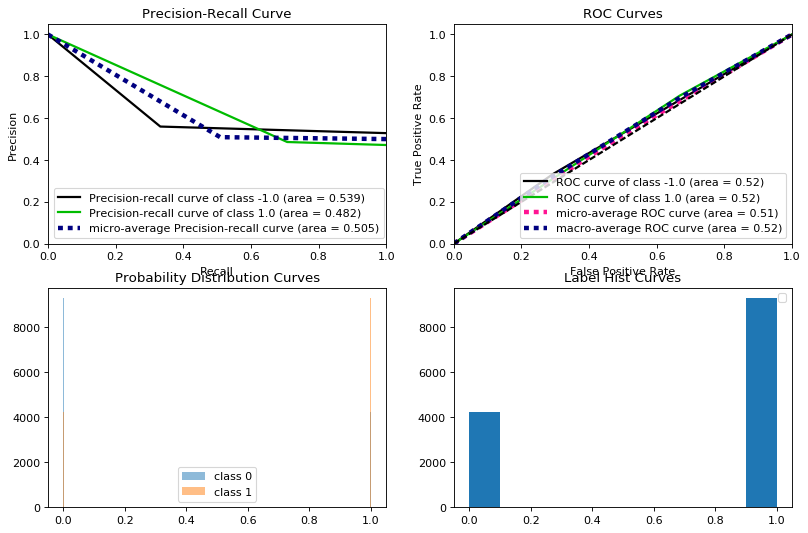

In [5]:
from sklearn.metrics import accuracy_score
import scikitplot.plotters as skplt

ypred_tree=clf_fit1.predict(Xtest.values)   #预测分类
yprob_tree=clf_fit1.predict_proba(Xtest.values) #预测不同类概率

acc=accuracy_score(ytest,ypred_tree)

print('决策树预测准确率=%f'%acc)

#函数：画ROC图
def draw_pic(ytest,yprob):
    '''
    画ROC + 概率分布 + 阈值胜率等
    :param y_test:              y分类
    :param yprob:               y分类预测概率
    :return:
    '''

    num_classes = len(np.unique(ytest))

    # plt.figure(num=pltnum,figsize=(12, 8), dpi=80)

    # 1.准确率
    ax1 = plt.subplot(2, 2, 1)
    skplt.plot_precision_recall_curve(ytest,yprob,ax=ax1)

    # 2.画ROC图
    ax2 = plt.subplot(2, 2, 2)
    skplt.plot_roc_curve(ytest, yprob, ax=ax2)

    # 3.画胜率概率图
    ax3 = plt.subplot(2, 2, 3)
    for i2 in range(yprob.shape[1]):
        plt.hist(yprob[:, i2], 300, alpha=0.5, label='class ' + str(i2))
    handles3, labels3 = ax3.get_legend_handles_labels()
    ax3.legend(handles3, labels3)
    plt.title('Probability Distribution Curves')

    # 4.画预测样本hist分布
    ypred = np.argmax(yprob, axis=1)
    ax4 = plt.subplot(2, 2, 4)
    plt.hist(ypred, 10)
    handles4, labels4 = ax4.get_legend_handles_labels()
    ax4.legend(handles4, labels4)
    plt.title('Label Hist Curves')

    # plt.draw()
    # plt.pause(0.01)
    
plt.figure(num=1,figsize=(12, 8), dpi=80)
#plt.close()
draw_pic(ytest,yprob_tree)
plt.show()

上图决策树的ROC图还是不错的，面积有0.49左右（关于ROC图，后面讲模型评价还会细说）

<h2> 2.4 随机森林模型 </h2>

随机森林属于集成学习（Ensemble Learning）中的bagging算法。所谓集成学习是使用一系列学习器进行学习，并使用某种

规则把各个学习结果进行整合从而获得比单个学习器更好的学习效果的一种机器学习方法。在集成学习中，主要分为bagging

算法和boosting算法。我们先看看这两种方法的特点和区别。

一、Bagging（套袋法）

bagging的算法过程如下：

1.从原始样本集中使用Bootstraping方法随机抽取n个训练样本，共进行k轮抽取，得到k个训练集。（k个训练集之间相互独立，

元素可以有重复）

2.对于k个训练集，我们训练k个模型（这k个模型可以根据具体问题而定，比如决策树，knn等）

3.对于分类问题：由投票表决产生分类结果；对于回归问题：由k个模型预测结果的均值作为最后预测结果。（所有模型的重要

性相同）

二、Boosting（提升法）

boosting的算法过程如下：

1.对于训练集中的每个样本建立权值wi，表示对每个样本的关注度。当某个样本被误分类的概率很高时，需要加大对该样本的权值。

2.进行迭代的过程中，每一步迭代都是一个弱分类器。我们需要用某种策略将其组合，作为最终模型。（例如AdaBoost给每个弱分

类器一个权值，将其线性组合最为最终分类器。误差越小的弱分类器，权值越大）

三、Bagging，Boosting的主要区别

1.样本选择上：Bagging采用的是Bootstrap随机有放回抽样；而Boosting每一轮的训练集是不变的，改变的只是每一个样本的权重。

2.样本权重：Bagging使用的是均匀取样，每个样本权重相等；Boosting根据错误率调整样本权重，错误率越大的样本权重越大。

3.预测函数：Bagging所有的预测函数的权重相等；Boosting中误差越小的预测函数其权重越大。

4.并行计算：Bagging各个预测函数可以并行生成；Boosting各个预测函数必须按顺序迭代生成。

因此简单讲 随机森林= Bagging + 决策树

下面通过案例，采用同样的数据，用随机森林模型（底层estimator估计器也是决策树）进行建模，与决策树模型进行对比。


In [6]:
#随机森林模型
from sklearn.ensemble import RandomForestClassifier

clf2=RandomForestClassifier(n_estimators=30,criterion='entropy')
clf_fit2=clf2.fit(Xtrain.values,ytrain.values) #训练

ypred_rf=clf_fit2.predict(Xtest.values)   #预测分类
yprob_rf=clf_fit2.predict_proba(Xtest.values) #预测不同类概率

acc=accuracy_score(ytest,ypred_rf)

print('随机森林预测准确率=%f'%acc)

随机森林预测准确率=0.532253


C:\HiData\Software\Anaconda3\envs\py36-shen\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_precision_recall_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_precision_recall_curve instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\HiData\Software\Anaconda3\envs\py36-shen\lib\site-packages\sklearn\utils\deprecation.py:77: DeprecationWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=DeprecationWarning)


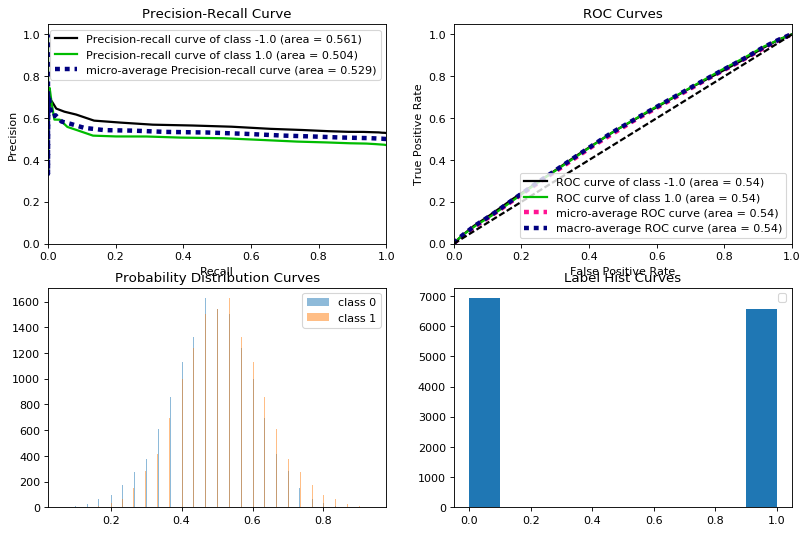

In [7]:
#随机森林画图
plt.figure(num=2,figsize=(12, 8), dpi=80)
draw_pic(ytest,yprob_rf)
plt.show()

对比决策树 vs 随机森林的准确率和ROC图形：

1. 随机森林准确率比决策树略高

2. 随机森林的概率分布（Probability Distribution Curves）更接近正态分布，决策树分布很集中

<h2> 2.5 过拟合、欠拟合 </h2>

